# Single asperity simulations in 2.5D medium

In this tutorial, we simulate slip on a single velocity-weakening asperity, embedded in 2.5d medium. 

Within 2.5D approximation, depth-distribution of slip is fixed, exact for case where Posson's ratio is zero (Luo and Ampuero, 2018; Weng and Ampuero, 2019)

We begin by importing some modules.


In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
base_dir = os.path.expanduser("~")
qdyn_dir = os.path.join(base_dir, "qdyn", "qdyn")
plot_dir = os.path.join(qdyn_dir, "utils", "post_processing")

sys.path.append(qdyn_dir)
sys.path.append(plot_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

To preprare a simulation, the global simulation and mesh parameters will have to be specified. This is done in three steps: 

1. Specify global parameters, like simulation duration, output resolution, mesh size, and default mesh values
2. Render the mesh (assigning default values to every element)
3. Override the default mesh parameter values to create heterogeneity in the simulation

In this simulation, the only heterogeneity stems from a lateral variation in the direct effect parameter $a$, which is chosen such that the asperity has $(a-b) < 0$, and such that the matrix has $(a - b) > 0$.

In [2]:
###### Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
ab_ratio = 0.8              # a/b of asperity
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width
W_LC = 40                   # Fault width to nucleation length ratio
L_W = 3                     # Fault length to width ratio
asperity_ratio = 3          # Total Length to the asperity length


# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 0         # Periodic fault
set_dict["TMAX"] = 15*t_yr      # Maximum simulation time [s]
set_dict["NTOUT_LOG"] = 1000  # Temporal interval (number of time steps) for log
set_dict["NTOUT_OT"] = 100     # Temporal interval (number of time steps) for time series output
set_dict["NTOUT_OX"] = 100     # Temporal interval (number of time steps) for snapshot output
set_dict["NXOUT_OX"] = 2       # Spatial interval (number of elements in x-direction) for snapshot output
set_dict["V_PL"] = 1e-9        # Plate velocity [m/s]
set_dict["MU"] = 3e10          # Shear modulus [Pa]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.9e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1.0e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"] * 0.99    # Initial velocity [s]

# Compute relevant length scales:
# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])

# Nucleation length [m]
Lc = Lb / cab_ratio

# # Width of asperity [m]
W = Lc * W_LC

# Asperity length [m]
L_asp = W*L_W

# Total length [m]
L = L_asp * asperity_ratio

# # Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))

# # Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)

# Printing out the lengths related to the fault
print('Process zone width:{:.2f}m'.format(Lb))
print('Nucleation length:{:.2f}m'.format(Lc))
print('Aseprity length:{:.2f}m'.format(L_asp))
print('Fault width:{:.2f}m'.format(W))
print('Grid length:{:.2f}m'.format(L/N))
print('# grids:{:.0f}'.format(N))

# # Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
set_dict["W"] = W

# # Location on the fault (middle) for time series output
set_dict["IC"] = N // 2

# """ Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

# """ Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
p.mesh_dict["A"] = set_dict["SET_DICT_RSF"]["B"] * (1 + cab_ratio*(1 - 2*np.exp(-(2*x/L_asp)**6)))

# Write input to qdyn.in
p.write_input()

# On Windows 10, set this flag to True 
# (see http://ydluo.github.io/qdyn/getting_started.html#additional-notes-for-windows-10-users)
p.W10_bash = False

Process zone width:12.00m
Nucleation length:60.00m
Aseprity length:7200.00m
Fault width:2400.00m
Grid length:1.32m
# grids:16384


To see the effect of setting a heterogeneous value of a over the mesh, we can plot $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


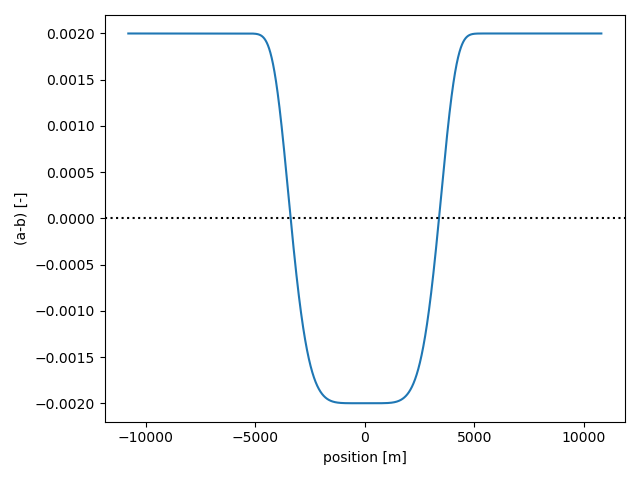

In [3]:
plt.clf()
plt.plot(x, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [m]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
plt.show()

As desired, the asperity is defined by $(a-b) < 0$, embedded in a stable matrix with $(a-b) > 0$.

The `p.write()` command writes a `qdyn.in` file to the current working directory, which is read by QDYN at the start of the simulation. To do this, call `p.run()`. Note that in this notebook, the screen output (`stdout`) is captured by the console, so you won't see any output here.

Also, note that simulations with large number of grid points 'N' may take a few minutes. 

In [4]:
# Lets remove if there are output files from the previous simulations
[os.remove(x) for x in os.listdir() if x.startswith('output')]
p.run()

True

During the simulation, output is flushed to disk every `NTOUT` time steps. This output can be reloaded without re-running the simulation, so you only have to call `p.run()` again if you made any changes to the input parameters. To read/process the output, call:

In [5]:
p.read_output()

True

For this tutorial, we use a library (`plot_functions.py`) that handles the plotting logistics. This library can be found in the `utils/post_processing` folder in the QDYN directory. To get a general impression of how our fault behaved, we plot the time series of the shear stress $\tau$ and state $\theta$ recorded at the centre of the fault, and the maximum slip rate $v_{max}$ recorded over the entire fault.

<IPython.core.display.Javascript object>


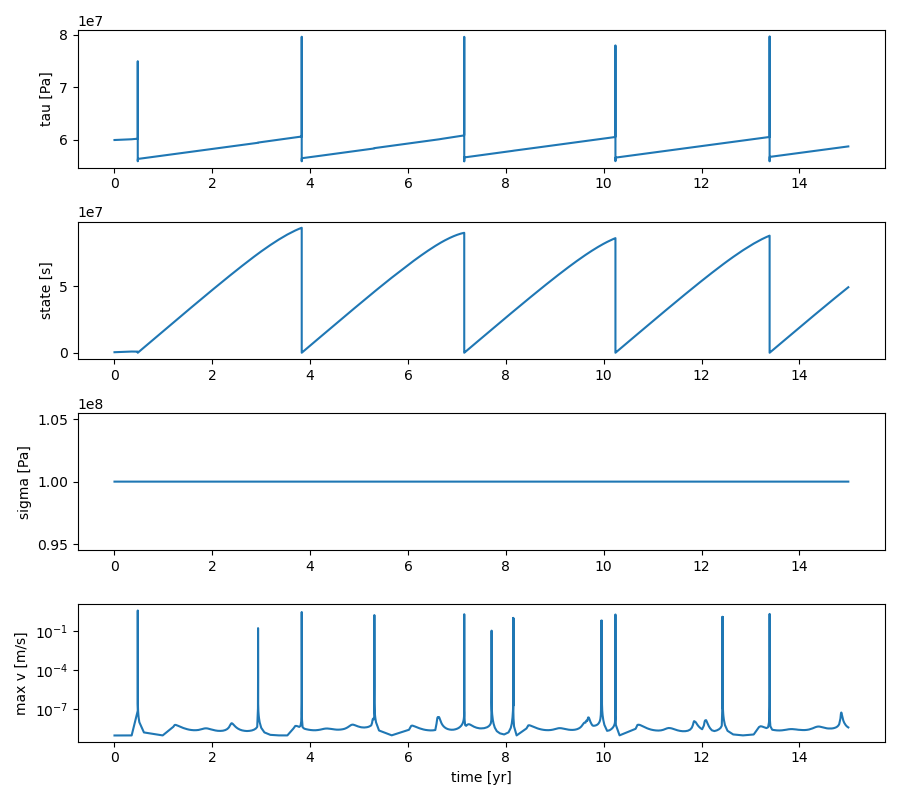

In [6]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

Small and quasi-periodic large earthquakes happen along this elongated fault (L>W) with 2.5D approximation. Now, let us see the slip profile.

480


<IPython.core.display.Javascript object>


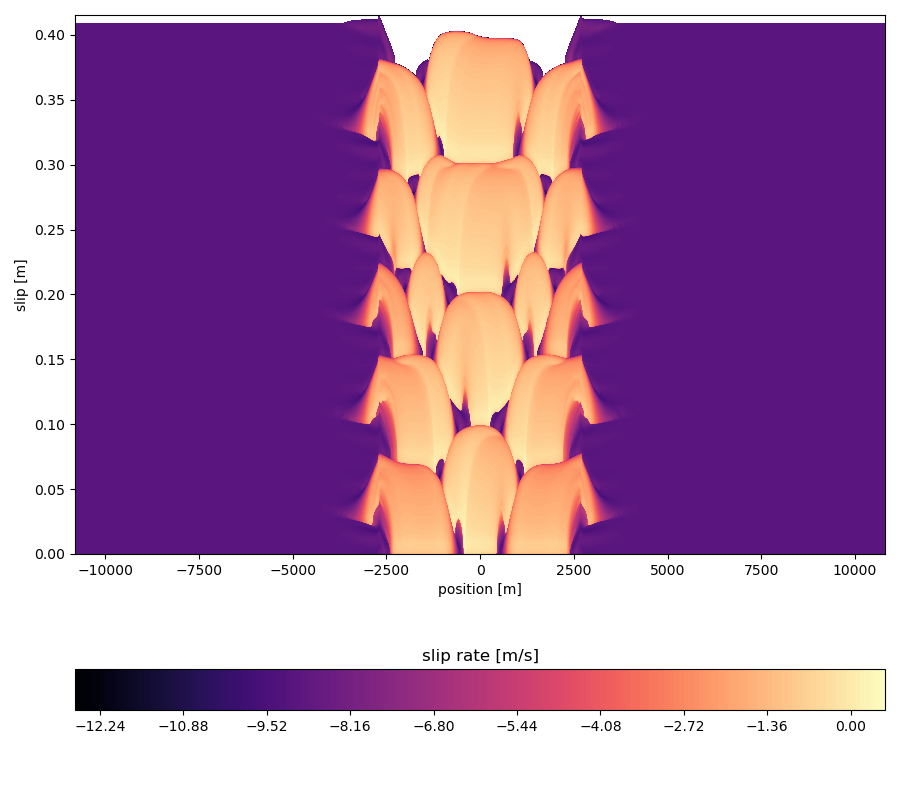

In [7]:
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, warm_up=2*t_yr)

Small earthquakes nucleate at the velocity strengthening-weakening transition and arrested within the aseprity. Large earthquakes nucleate where the small earthquake stopped and propagates mostly unilaterally. You may want to continue simulation a bit further to see what happens next. 

Now let's check the propagation in the middle of the asperity. 

<IPython.core.display.Javascript object>


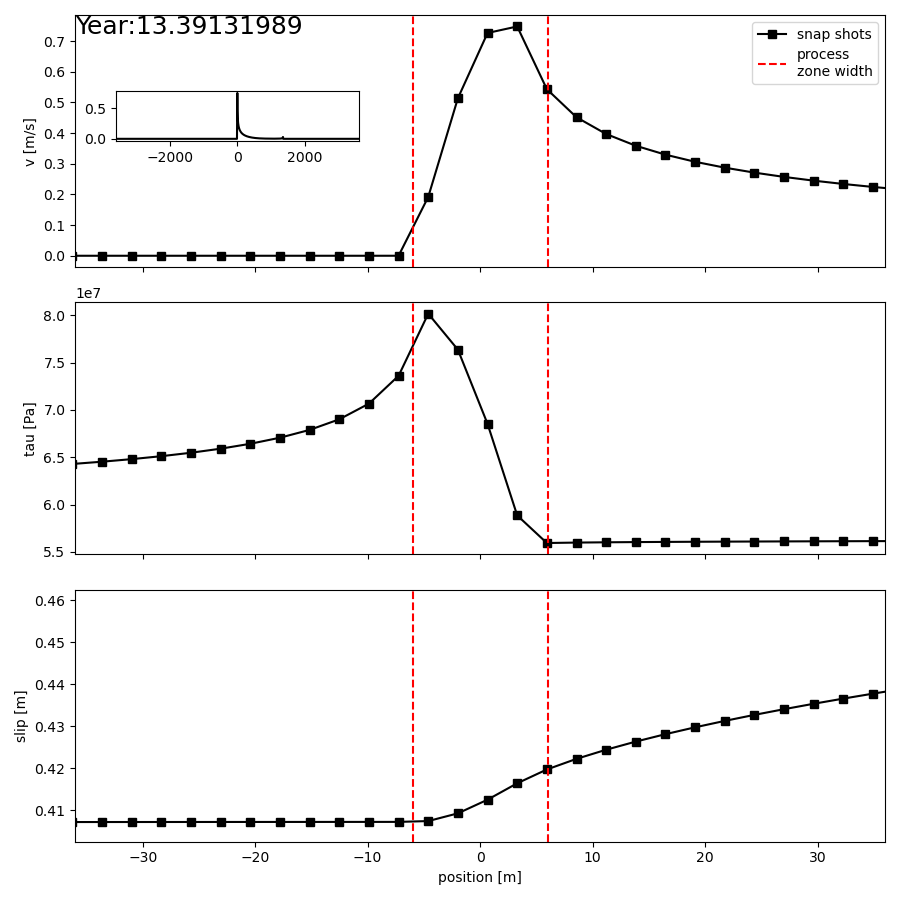

In [9]:
## PLOTTING RUPTURE PROPAGATION AND THE PROCESS ZONE

# Get the pandas dataframe of the snapshot time series.
# The warm up cycle is removed with a condition.
df_ot = p.ot[0][p.ot[0]['t']>13*t_yr] 

# Find the when the time series has the highest slip rate.
ot_step_max = df_ot[df_ot['v']==df_ot['v'].max()]['step'].values[0]

# To match the corresponding step among the outputs get the unique steps
ox_step_unique = p.ox['step'].unique()

# Search the closest step among the snapshots. 
# Since the output intervals are not the same there may have slight time shifts.
ox_step_max = ox_step_unique[np.abs(ox_step_unique - ot_step_max).argmin()]

# The Pandas dataframe corresponds to the highest slip rate.
ox_max = p.ox[p.ox['step']==ox_step_max]


#------- PLOT THE SNAPSHOTS -------#
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex =True, figsize= (9,9))
# slip rate
ax1.text(0,1, 'Year:{:.8f}'.format(ox_max.iloc[0]['t']/t_yr), 
         horizontalalignment='left', 
         verticalalignment='top', 
         transform=ax1.transAxes,
         fontsize= 18)

ax1.plot(ox_max['x'], ox_max['v'], 'k-s', label = 'snapshots')
ax1.axvline(-Lb/2, color = 'r', ls = '--', label = 'process\nzone width')
ax1.axvline(Lb/2, color = 'r', ls = '--')
ax1_ins = ax1.inset_axes([0.05,0.5,0.3,0.2])
ax1_ins.plot(ox_max['x'], ox_max['v'], color = 'k')
ax1_ins.set_xlim([-L_asp/2, L_asp/2])


ax1.set_ylabel('v [m/s]')
# shear stress
ax2.plot(ox_max['x'], ox_max['tau'], 'k-s')
ax2.axvline(-Lb/2, color = 'r', ls = '--')
ax2.axvline(Lb/2, color = 'r', ls = '--')
ax2.set_ylabel('tau [Pa]')
# slip
slip_0 = ox_max.iloc[len(ox_max['slip'])//2]['slip']
ax3.plot(ox_max['x'], ox_max['slip'], 'k-s')
ax3.axvline(-Lb/2, color = 'r', ls = '--')
ax3.axvline(Lb/2, color = 'r', ls = '--')
ax3.set_ylabel('slip [m]')
ax3.set_ylim((slip_0-0.01,slip_0+0.05))

ax1.set_xlim(-3*Lb,3*Lb)
ax3.set_xlabel('position [m]')
ax1.legend(loc=1)
plt.tight_layout()
fig.show()

The slip propagation at the specified time instance in the middle of the asperity is plotted as velocity, shear stress, and slip from top to bottom. The squares are the snapshots when the middle of asperity has the highest slip rate, and the red dashed lines define the nucleation zone width. Please note that the output is snapshotted every two grid intervals. The figure is an example of slip pulse propagation, such that slip localizes in the process zone and rates are substantially lower behind the pulse (see inset figure).   

Now, let us check the slip rates during the rupture. 

<IPython.core.display.Javascript object>


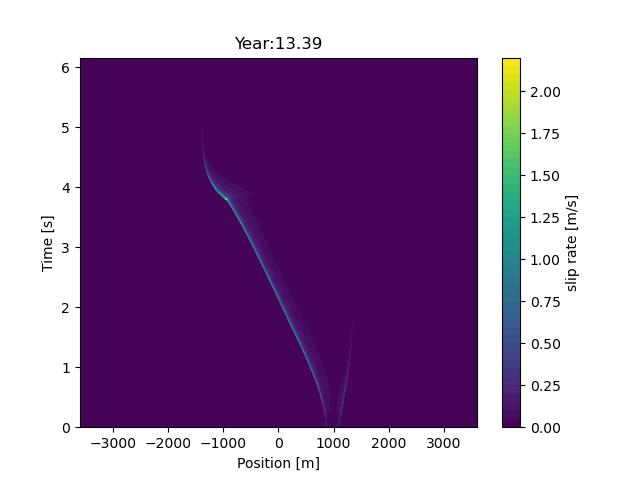

In [11]:
## SLIP RATE PROPAGATION
# Get the vmax values for between t1 and t2 time intervals.
t1 = 13* t_yr
t2 = 14* t_yr
df_ot_vmax = p.ot_vmax[(p.ot_vmax['t']>t1)&(p.ot_vmax['t']<t2)]

#Now lets filter them for high slip rates 
vc = 5e-3  # velocity threshold 
df_ot_vmax = df_ot_vmax[df_ot_vmax['v']>vc]

# Get the step values beginning and ceasing the rupture.
step1 = df_ot_vmax['step'].min()
step2 = df_ot_vmax['step'].max()

# Now lets filter the dense snapshots to get the rupture moment
ox_rup = p.ox[(p.ox['step']>step1) & (p.ox['step']<step2)]

t0 = ox_rup.iloc[0]['t']
fig1, axx = plt.subplots(1,1)
ctf = axx.tricontourf(ox_rup['x'], ox_rup['t']-t0, ox_rup['v'], levels = 50)
plt.title('Year:{:.2f}'.format(t0/t_yr))
axx.set_xlabel('Position [m]')
axx.set_ylabel('Time [s]')
cbar = fig.colorbar(ctf, ax=axx)
cbar.ax.set_ylabel('slip rate [m/s]')
# to better visualize, limit the plot
axx.set_xlim([-L_asp/2,L_asp/2])
# axx.set_ylim([0,3]) 
fig.tight_layout()

The slip rate profile for the specified rupture shows how a slip pulse propagates. Two pulses propagate; while the left one is stronger, the right branch dies after. We also see a change in propagation speed depending on the slip deficit on the medium due to the previous ruptures. The slip pulse propagation differs substantially from the crack growth in Exercise 2.

You may also check the animation with the below code. 

In [ ]:
# This will take a minute or two...
qdyn_plot.animation_slip(p.ox, warm_up=8*t_yr)

##### Exercise

Compare the results with the Exercise 2 (Single asperity). In Exercise 2, the width (W) was several times larger than the length.

Now try decrease LW_ratio less than 3 (like 'LW_ratio=1' or even lower) to see how the nucleation and propagation change.